In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data_watches.csv')
df.columns = [col.replace(' ', '_').replace('(', '').replace(')', '') for col in df.columns]
df.columns = [col.replace(',_до', '') for col in df.columns]

In [3]:
# Определение переменных

# Регрессоры
X = df.loc[:, ~df.columns.isin(['Название', 'Цена', 'Ссылка'])]
X['const'] = 1 # Добавление константы

# Описание всех переменных
descr = X.describe()

# Количественные переменные
quant_var = list(descr.loc['max', :][descr.loc['max', :] != 1].index)

# Dummy переменные
dummy_var = list(descr.loc['max', :][descr.loc['max', :] == 1].index)

# Целевая переменная - цена часов
df['Лог_цена'] = np.log(df['Цена'])

/var/folders/09/_8mjdc0s6f3gncfnf5n7sp6w0000gn/T/ipykernel_55641/2527806189.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['const'] = 1 # Добавление константы


In [4]:
# Построим квантильную регрессию только на количественных переменных.
quant_var = list(descr.loc['max', :][descr.loc['max', :] != 1].index)
X_y = df[['Лог_цена'] + quant_var]
yr_regr = 'Лог_цена ~ ' + ' + '.join(quant_var)

In [5]:
model_q01 = smf.quantreg(yr_regr, X_y).fit(q=0.1)
model_q09 = smf.quantreg(yr_regr, X_y).fit(q=0.9)

In [6]:
differ = model_q09.predict() - model_q01.predict()
centr = differ / 2 + model_q01.predict()

In [7]:
predicted_table = pd.DataFrame({'Лог_цена': df['Лог_цена'], 
                                'Нижний квантиль': model_q01.predict() , 
                                'Верхний квантиль': model_q09.predict(),
                                'Разница между квантилем 09 и 01': differ,
                                'Центрирование': centr
                               })

predicted_table.sort_values(by='Разница между квантилем 09 и 01', inplace=True)
predicted_table['Центрированные цены'] = predicted_table['Лог_цена'] - predicted_table['Центрирование']

predicted_table['Нижний квантиль'] = predicted_table['Нижний квантиль'] - predicted_table['Центрирование']
predicted_table['Верхний квантиль'] = predicted_table['Верхний квантиль'] - predicted_table['Центрирование']

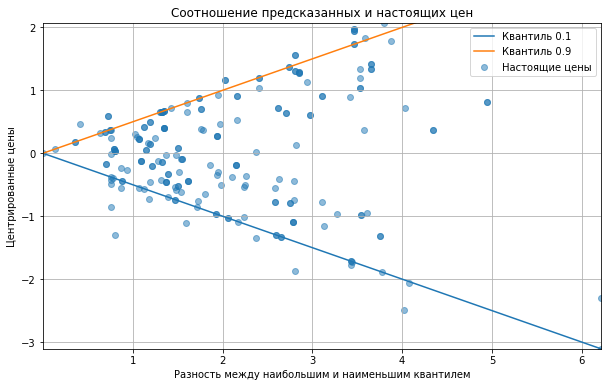

In [8]:
plt.figure(figsize=(10, 6))
plt.scatter(predicted_table['Разница между квантилем 09 и 01'], predicted_table['Центрированные цены'], alpha=0.5, label='Настоящие цены')

plt.title('Соотношение предсказанных и настоящих цен')
plt.xlabel('Разность между наибольшим и наименьшим квантилем')
plt.ylabel('Центрированные цены')

plt.plot(predicted_table['Разница между квантилем 09 и 01'], predicted_table['Нижний квантиль'], label='Квантиль 0.1')
plt.plot(predicted_table['Разница между квантилем 09 и 01'], predicted_table['Верхний квантиль'], label='Квантиль 0.9')
plt.legend()

plt.grid(True)  # Добавление сетки

# Добавление диапазонов значений для каждой оси
plt.xlim(predicted_table['Разница между квантилем 09 и 01'].min(), predicted_table['Разница между квантилем 09 и 01'].max())
plt.ylim(predicted_table['Центрированные цены'].min(), predicted_table['Центрированные цены'].max())

plt.show()


In [9]:
class QuantileRegressor:
    def __init__(self, df: pd.DataFrame, features: list, target_name: str, step: float = 0.05) -> None:
        self.features = features
        self.quantile_list = np.arange(0.05, 0.95, step).tolist()
        self.results = self.perform_regression(df, features, target_name)

    def perform_regression(self, df, features, target_name):
        results = {}
        features_in_regression_form = f'{target_name} ~ ' + ' + '.join(features)
        for quantile in self.quantile_list:
            quantile_regression = smf.quantreg(features_in_regression_form, df).fit(q=quantile)
            temp_data = quantile_regression.conf_int().rename(columns={0: 'niz', 1: 'verh'})
            temp_data['w'] = quantile_regression.params
            results[quantile] = temp_data
        return results

    def plot_quantile_analysis(self, feature: str) -> None:
        plt.figure(figsize=(16, 6))
        for quantile in self.quantile_list:
            niz, verh, w = self.results[quantile].loc[feature].tolist()
            plt.plot([quantile, quantile], [niz, verh], color='blue', alpha=0.2)
            plt.scatter(quantile, w, color='red', marker='o')
        plt.axhline(0, color='black', linestyle='--', linewidth=1)
        plt.xlabel('Квантиль')
        plt.ylabel('Коэффициент')
        plt.title(f'Коэффициент перед {feature} у квантильных регрессий разного уровня')
        plt.show()

build_quantile = QuantileRegressor(df=X_y, features=quant_var, target_name='Лог_цена', step=0.05)

/Users/maxim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


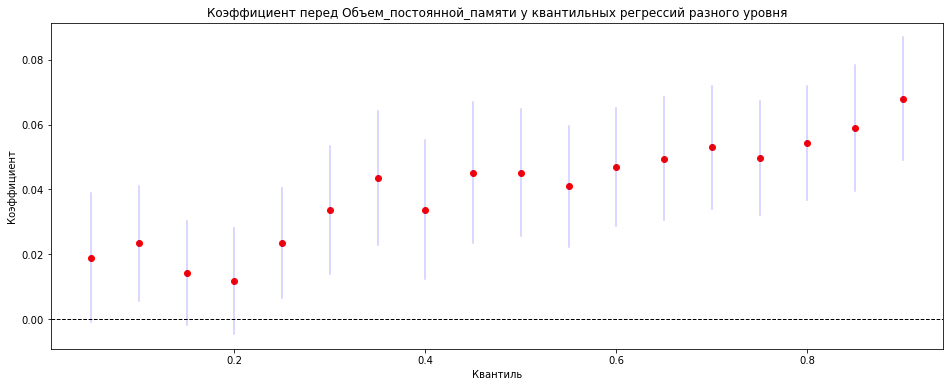

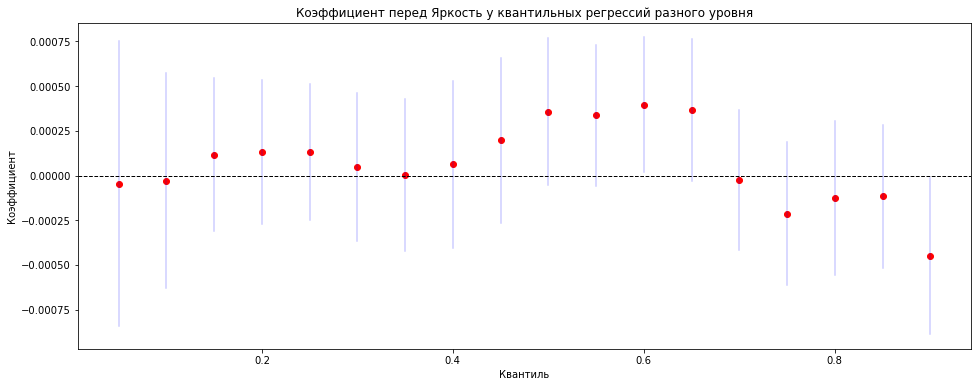

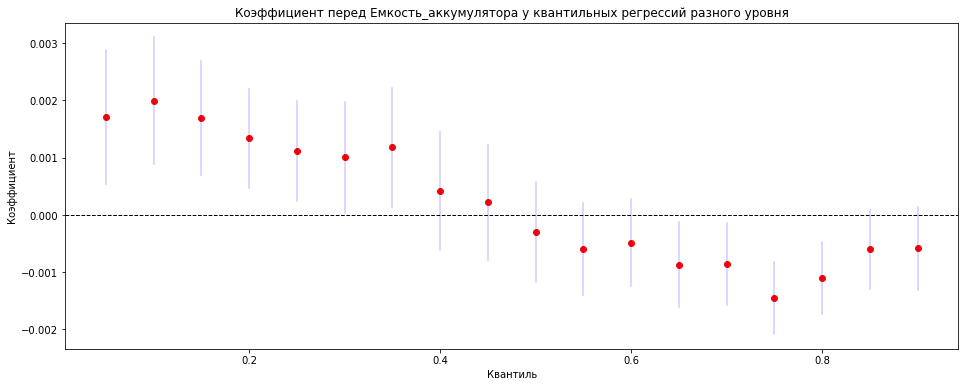

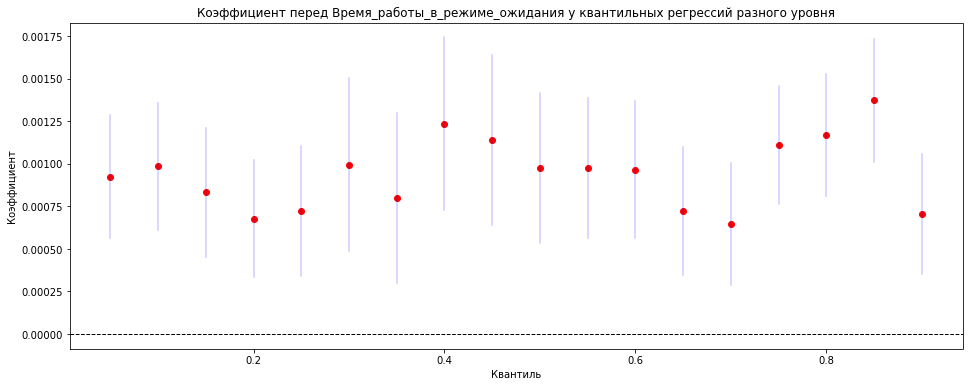

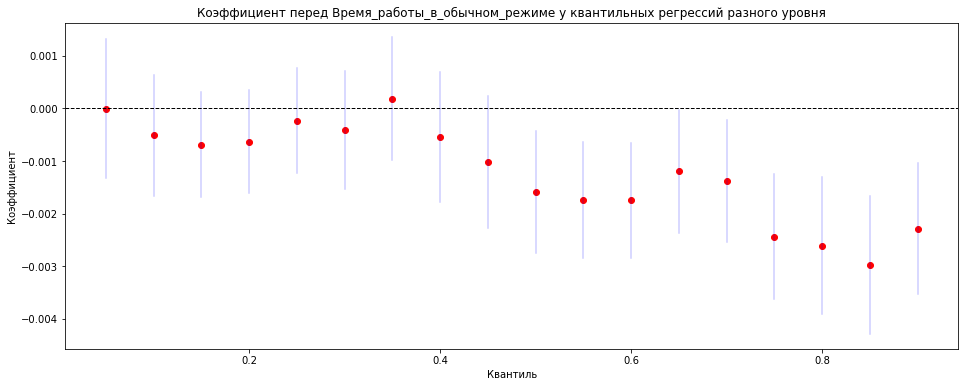

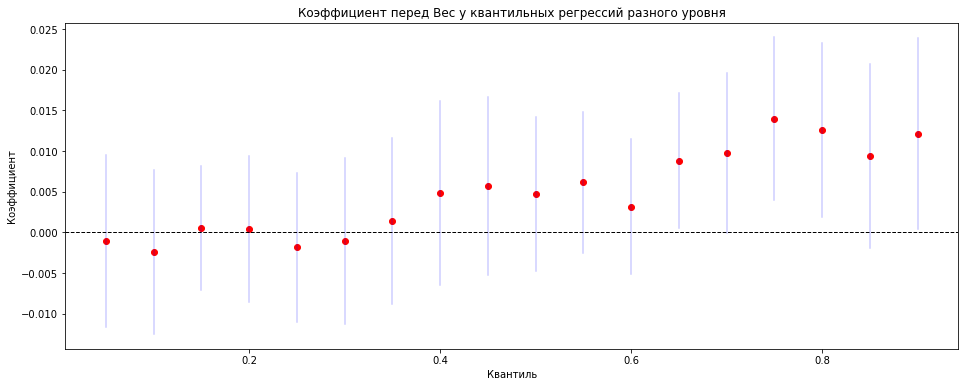

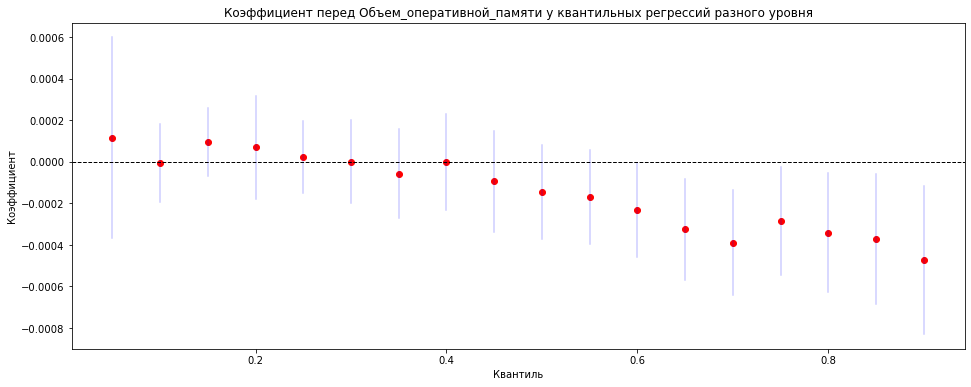

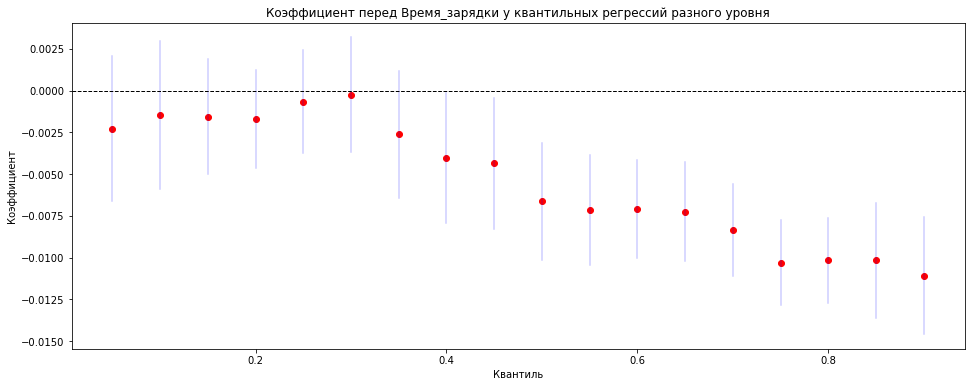

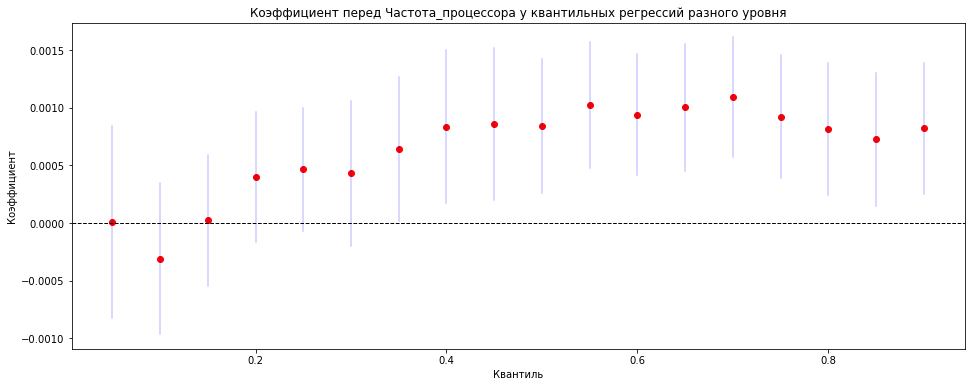

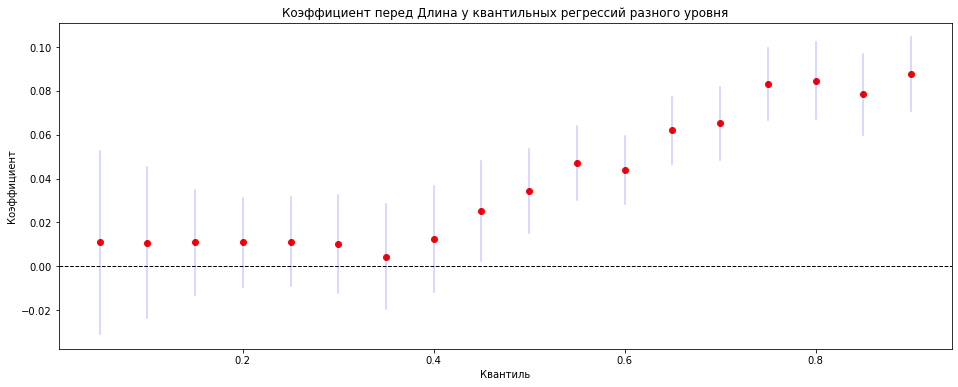

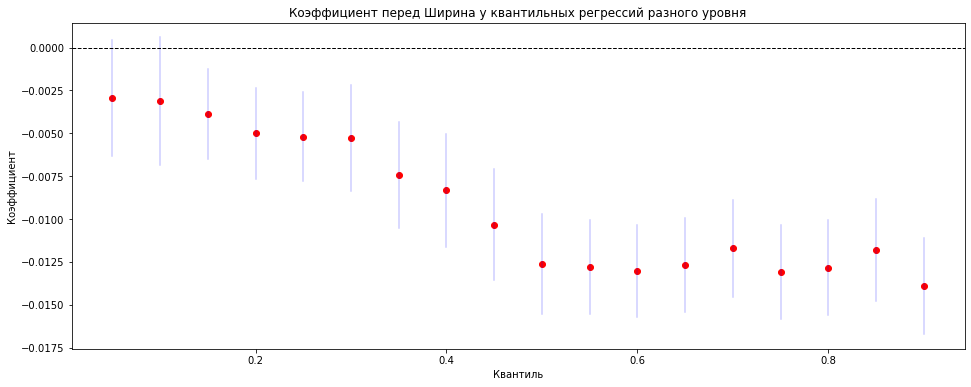

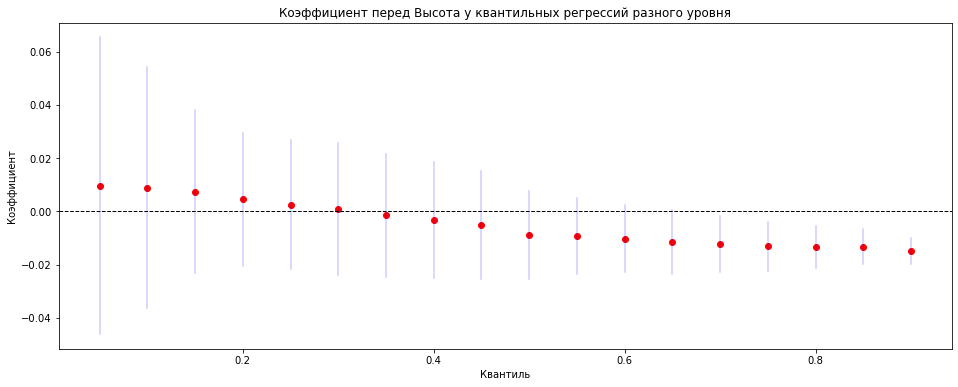

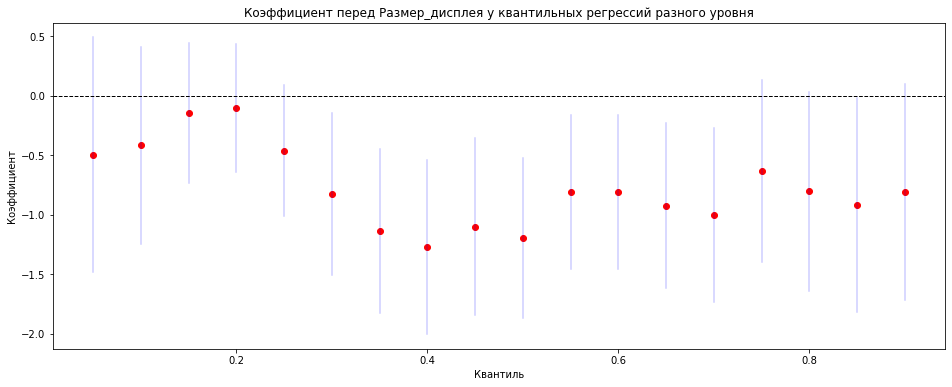

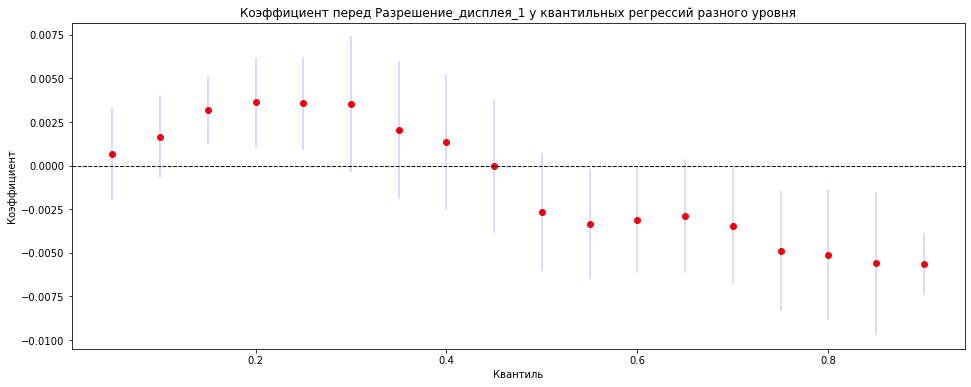

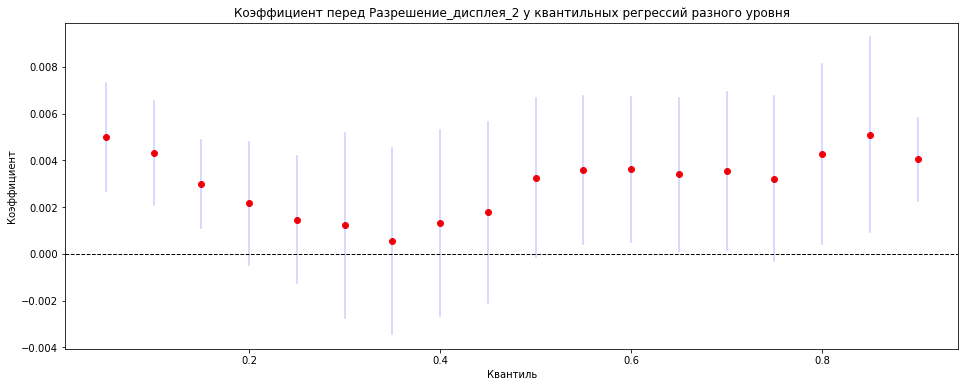

In [10]:
for i in range(len(quant_var)):
    build_quantile.plot_quantile_analysis(quant_var[i])

In [13]:
model_q01 = smf.quantreg(yr_regr, X_y).fit(q=0.1)
model_q01.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:               Лог_цена   Pseudo R-squared:               0.4394
Model:                       QuantReg   Bandwidth:                      0.6823
Method:                 Least Squares   Sparsity:                        2.806
Date:                Fri, 10 May 2024   No. Observations:                  222
Time:                        20:43:37   Df Residuals:                      206
                                        Df Model:                           15
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          5.7031      1.454      3.922      0.000       2.837       8.570
Объем_постоянной_памяти            0.0234      0.009      2.610      0.010       0.006       0.041
Яркость                        -2.886e-05      0.000     -0.095      0.925      -0.001       0.001
Емкость_аккумулятора               0.0020      0.001      3.539      0.000       0.001       0.003
Время_работы_в_режиме_ожидания     0.0010      0.000      5.166      0.000       0.001       0.001
Время_работы_в_обычном_режиме     -0.0005      0.001     -0.879      0.380      -0.002       0.001
Вес                               -0.0024      0.005     -0.477      0.634      -0.012       0.008
Объем_оперативной_памяти       -6.355e-06   9.54e-05     -0.067      0.947      -0.000       0.000
Время_зарядки                     -0.0015      0.002     -0.654      0.514      -0.006       0.003
Частота_процессора                -0.0003      0.000     -0.934      0.351      -0.001       0.000
Длина                              0.0108      0.018      0.617      0.538      -0.024       0.045
Ширина                            -0.0031      0.002     -1.659      0.099      -0.007       0.001
Высота                             0.0089      0.023      0.388      0.699      -0.036       0.054
Размер_дисплея                    -0.4187      0.420     -0.996      0.321      -1.248       0.410
Разрешение_дисплея_1               0.0017      0.001      1.423      0.156      -0.001       0.004
Разрешение_дисплея_2               0.0043      0.001      3.806      0.000       0.002       0.007
==================================================================================================

The condition number is large, 3.54e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
model_q09 = smf.quantreg(yr_regr, X_y).fit(q=0.9)
model_q09.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:               Лог_цена   Pseudo R-squared:               0.5009
Model:                       QuantReg   Bandwidth:                      0.6757
Method:                 Least Squares   Sparsity:                        2.412
Date:                Fri, 10 May 2024   No. Observations:                  222
Time:                        20:44:47   Df Residuals:                      206
                                        Df Model:                           15
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          9.7795      0.850     11.507      0.000       8.104      11.455
Объем_постоянной_памяти            0.0679      0.010      7.062      0.000       0.049       0.087
Яркость                           -0.0005      0.000     -2.040      0.043      -0.001   -1.51e-05
Емкость_аккумулятора              -0.0006      0.000     -1.590      0.113      -0.001       0.000
Время_работы_в_режиме_ожидания     0.0007      0.000      3.932      0.000       0.000       0.001
Время_работы_в_обычном_режиме     -0.0023      0.001     -3.622      0.000      -0.004      -0.001
Вес                                0.0122      0.006      2.036      0.043       0.000       0.024
Объем_оперативной_памяти          -0.0005      0.000     -2.617      0.010      -0.001      -0.000
Время_зарядки                     -0.0111      0.002     -6.243      0.000      -0.015      -0.008
Частота_процессора                 0.0008      0.000      2.834      0.005       0.000       0.001
Длина                              0.0876      0.009     10.272      0.000       0.071       0.104
Ширина                            -0.0139      0.001     -9.807      0.000      -0.017      -0.011
Высота                            -0.0148      0.002     -5.935      0.000      -0.020      -0.010
Размер_дисплея                    -0.8072      0.460     -1.753      0.081      -1.715       0.100
Разрешение_дисплея_1              -0.0056      0.001     -6.486      0.000      -0.007      -0.004
Разрешение_дисплея_2               0.0040      0.001      4.478      0.000       0.002       0.006
==================================================================================================

The condition number is large, 3.54e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""